<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은
<font color = blue>정답 값이 들어올 때 훈련없이 그 정답 값을 이용해서 다음 값을 예측한 것이다</font>

[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

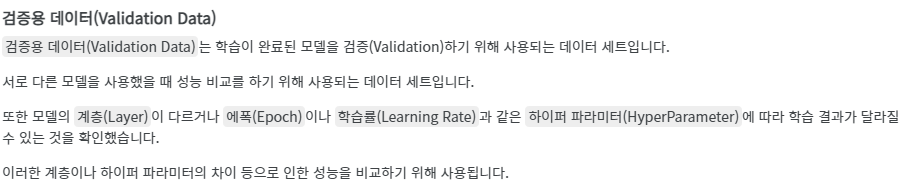
https://076923.github.io/posts/Python-pytorch-11/<br>
&rightarrow; 현재 검증을 통해서 모델을 비교하는 것이 아니기 때문에 Train20일 Test 7일로 나누겠다
<br>
validation set으로 하이퍼파라미터 튜닝을 위해서는 Ray Library를 이용하자

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['1step-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('1step-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'1step-DLinear')

['/hdd_1/sjlee/Paper_Project/1step-DLinear']

In [5]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [6]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [7]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['1step-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['1step-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['1step-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['1step-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() # 새로로 펼친걸 가로로 늘림
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [8]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [9]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_494699/824785221.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [10]:
x_seq.size()

torch.Size([27360, 1, 1440])

In [11]:
for x in range(2):
    f = lambda x: x*2
    print(f(x))

0
2


In [12]:
import torch.optim as optim

In [13]:
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config)
optimizer = Adam(model.parameters(),lr=1e-5)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남
# 파이토치 schedular https://wikidocs.net/157282
criterion = SMAPE()

Adjusting learning rate of group 0 to 1.0000e-05.


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

-> 쉽게 이해하자면 역전파를 보낼때마다 초기화를 시켜줘야하는데 이전값이 영향을 주고 있는 셈

In [14]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
        
    scheduler.step() #schedular update
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-06.
smape 7.382657362259816 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 6.146066110425939 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 5.87617275942313 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 5.393119054323617 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 4.812032209310343 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 4.639010349103407 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 4.463973527567254 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 4.169773495700265 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 4.030171022151341 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 3.844846451467132 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 3.749518692724908 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 3.562953214158375 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 3.407761088806635 %
Adjusting lea

In [15]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    if idx == 0:
        new_train = torch.FloatTensor(
            [X.iloc[-sequence_length:].values]
        ).view(1,1,sequence_length).to(device)
        
    elif idx < sequence_length:
        new_train = torch.FloatTensor(
            [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,1,sequence_length).to(device)
    elif idx >= sequence_length:
        new_train = torch.FloatTensor(
            [target.iloc[idx-sequence_length:idx].values]
            ).view(1,1,sequence_length).to(device)

    with torch.no_grad():
        model.eval()
        out = model(new_train) # 예측완료
        end = time.time()
        pred_list.append(out.cpu().view(1).item())
        time_list.append(end-start)

In [16]:
len(pred_list)

10080

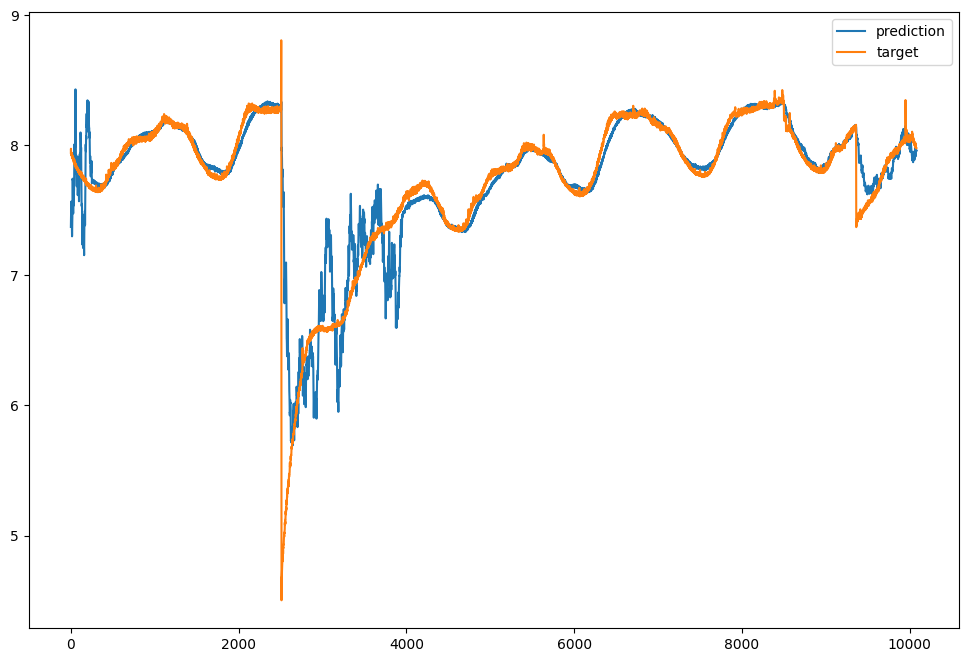

In [17]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [18]:
np.array(pred_list)

array([7.3718853 , 7.40300274, 7.46587658, ..., 7.9519496 , 7.96487284,
       7.96049309])

In [19]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[7.941656],
       [7.972712],
       [7.94328 ],
       ...,
       [7.980072],
       [7.974312],
       [7.976136]])

In [20]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [21]:
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100

In [22]:
print('score',score.item(),'%')

score 1.4011681079864502 %


In [25]:
new_pred_list=[i+0.1 for i in pred_list]# 단순히 sliding된건 아닌지 확인하기 위해

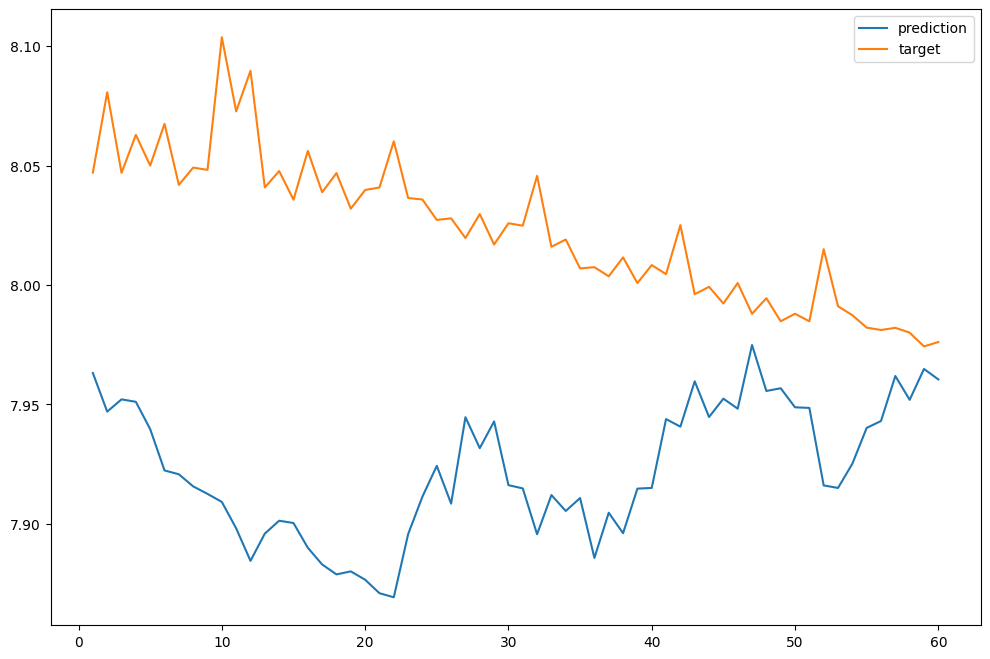

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

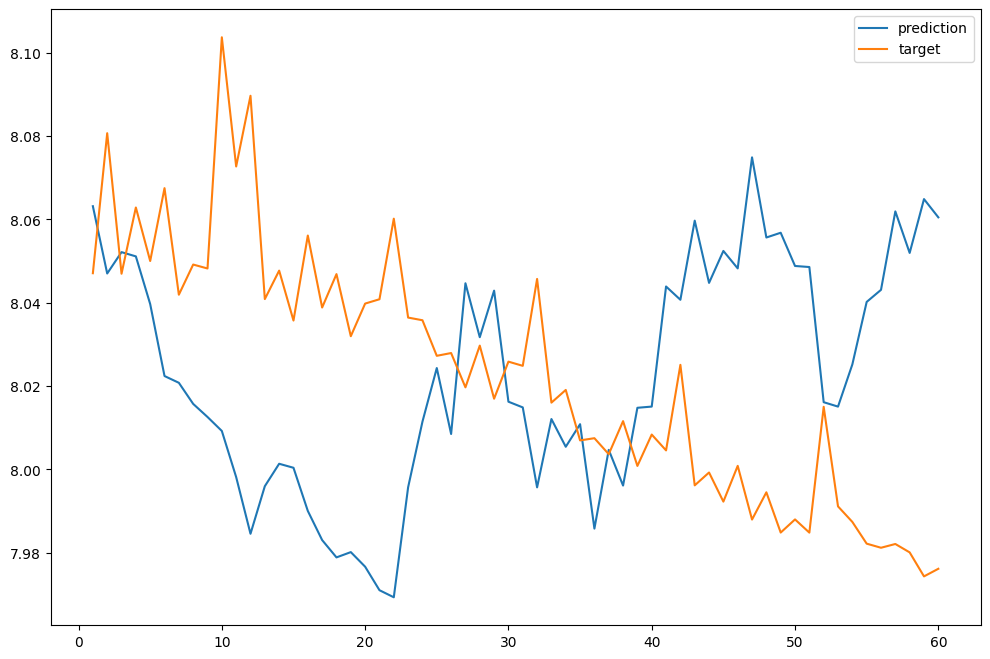

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),new_pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

<font color =blue> 단순 sliding은 아닌듯 하다 </font>

<font color = blue><font size = 6> Conclusion </font></font><br>
이번 결과는 1step마다 예측을 진행한 결과이다 현재 목표는 바로 다음시점(여기서는 1분후)를 잘 예측하는 것이 목적이다 그런 측면에서 본다면 이전까지의 데이터에 대한 의존성이 큰 문제가 되지는 않지만 다른 말로 하자면 데이터가 제공되지 않는 구간이 생긴다면 예측에 오류가 생길것이다 이는 곧 데이터가 제공되지 않고 나의 이전 예측으로 다음시점을 예측하는데에는 불리하다는 말이 된다<br><font color = blue>
하지만 현재의 가정은 데이터가 계속해서 제공이 될때 바로 앞을 예측하는 것이기 때문에 괜찮다</font>